<a href="https://colab.research.google.com/github/deepak4728/AiEnsured_Intern_Project/blob/main/Veggies_Classification_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Imports and Dataset Fetch**

**Drive Connect**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Imports**

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("misrakahmed/vegetable-image-dataset")

print("Path to dataset files:", path)

100%|██████████| 534M/534M [00:07<00:00, 79.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/misrakahmed/vegetable-image-dataset/versions/1


In [ ]:
import random
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dense, SpatialDropout2D, Dropout


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

**Constants**

In [ ]:
Veggies_count = 15
target_size = (128, 128)


In [ ]:
base_dir = os.path.join(path, 'Vegetable Images')
print(base_dir)
train_dir = os.path.join(base_dir, 'train')
print(train_dir)

/root/.cache/kagglehub/datasets/misrakahmed/vegetable-image-dataset/versions/1/Vegetable Images
/root/.cache/kagglehub/datasets/misrakahmed/vegetable-image-dataset/versions/1/Vegetable Images/train


##**Utility Functions**

In [ ]:
def load_vegetable_datasets(base_dir, img_size=target_size, batch_size=32):

    train_dir = os.path.join(base_dir, 'train')
    val_dir = os.path.join(base_dir, 'validation')
    test_dir = os.path.join(base_dir, 'test')

    # Define a normalization layer
    normalization_layer = tf.keras.layers.Rescaling(1./255)

    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir,
        labels='inferred',
        label_mode='int',  # use 'categorical' if you want one-hot encoding
        image_size=img_size,
        batch_size=batch_size,
        shuffle=True
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        val_dir,
        labels='inferred',
        label_mode='int',
        image_size=img_size,
        batch_size=batch_size,
        shuffle=True
    )

    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        test_dir,
        labels='inferred',
        label_mode='int',
        image_size=img_size,
        batch_size=batch_size,
        shuffle=False
    )

    # Get class names before applying map
    class_names = train_ds.class_names

    # Apply normalization to the datasets
    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
    test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))


    return train_ds, val_ds, test_ds, class_names

In [ ]:
def plot_training_history(history):
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])

    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    if val_acc:
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    if val_loss:
        plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(model, test_ds, class_names):

    # Get the true labels and predicted labels for the test set
    test_labels = np.concatenate([y for x, y in test_ds], axis=0)
    predictions = model.predict(test_ds)

    # Apply softmax to get probabilities and then get the predicted class
    predicted_labels = np.argmax(tf.nn.softmax(predictions, axis=1), axis=1)

    # Compute the confusion matrix
    cm = confusion_matrix(test_labels, predicted_labels)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

##**Load Dataset**

In [ ]:
train_ds, val_ds, test_ds, class_names = load_vegetable_datasets(base_dir)

Found 15000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


##**Dataset Preview**

Found 15 classes: ['Brinjal', 'Capsicum', 'Broccoli', 'Papaya', 'Pumpkin', 'Radish', 'Cucumber', 'Cabbage', 'Bitter_Gourd', 'Bean', 'Potato', 'Bottle_Gourd', 'Tomato', 'Cauliflower', 'Carrot']


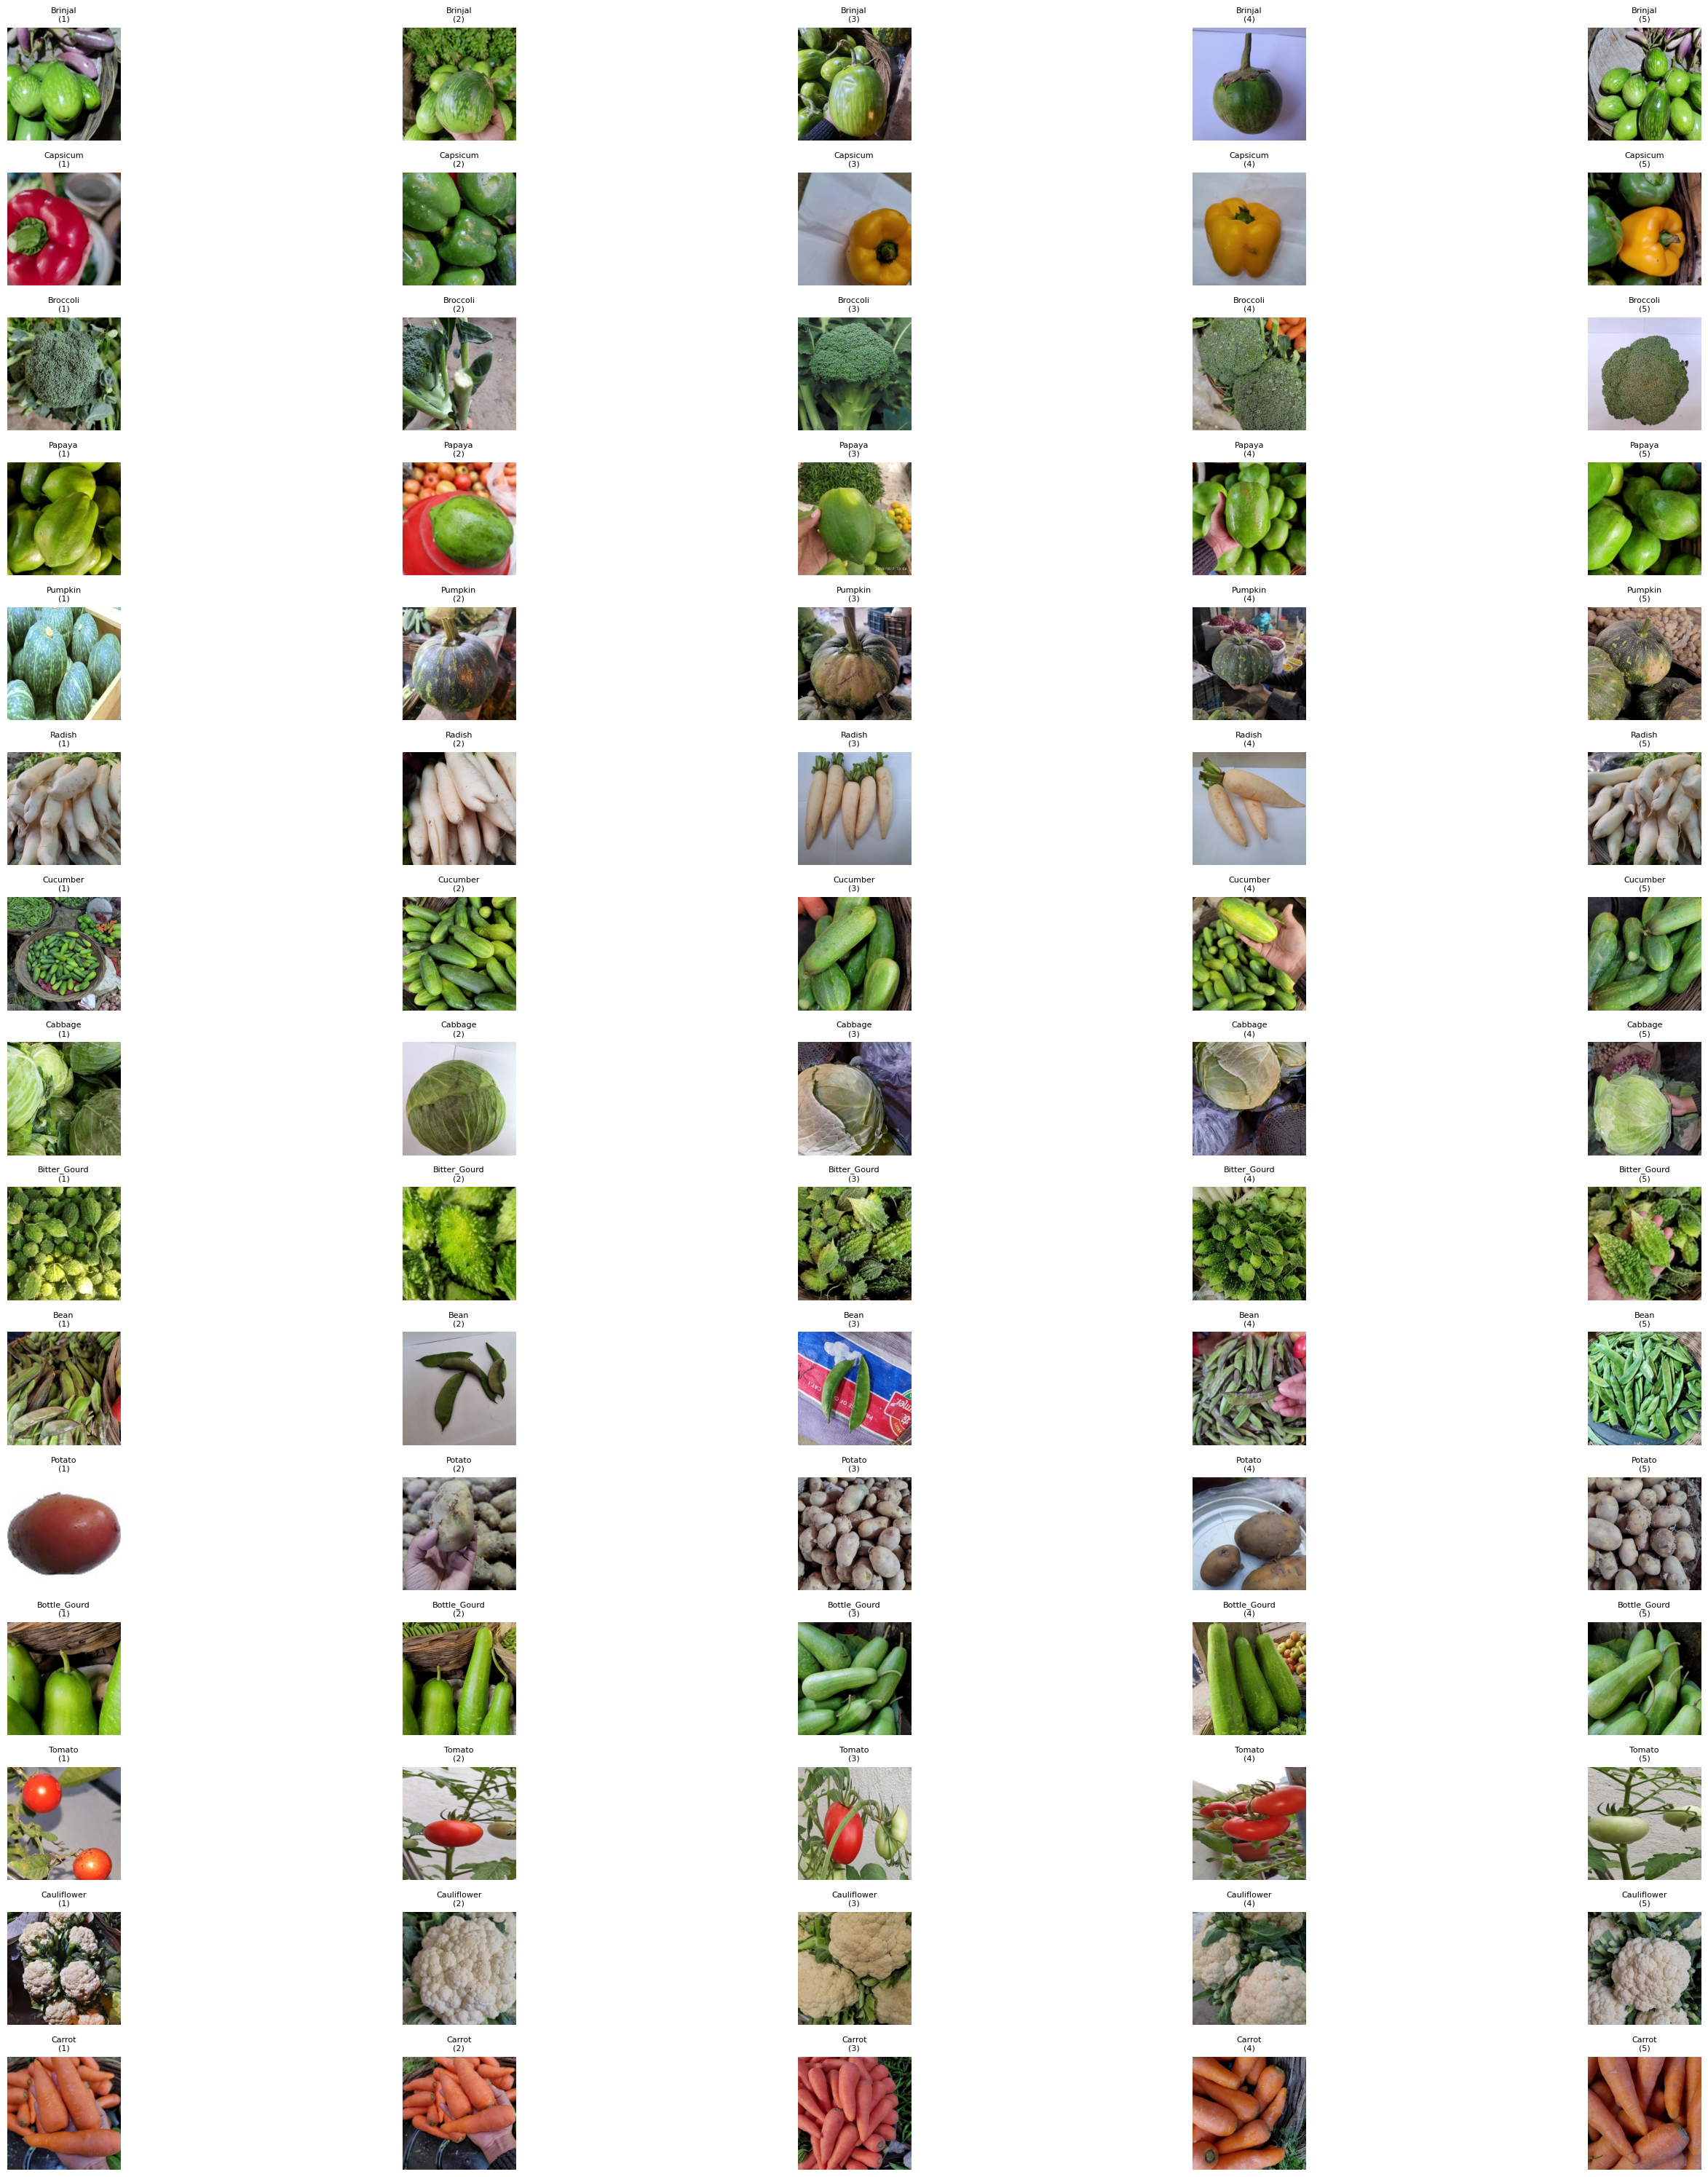

In [ ]:
def display_image_previews(data_dir):
    """
    Displays a preview of 4-5 images from each class in the dataset.

    Args:
        data_dir (str): Path to the root directory of the dataset.
    """
    class_names = os.listdir(data_dir)
    print(f"Found {len(class_names)} classes: {class_names}")

    plt.figure(figsize=(30, 30)) # Increased figure size
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            images = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith(('png', 'jpg', 'jpeg'))]
            # Select up to 5 random images
            preview_images = random.sample(images, min(len(images), 5))

            for j, img_path in enumerate(preview_images):
                plt.subplot(len(class_names), 5, i * 5 + j + 1)
                img = plt.imread(img_path)
                plt.imshow(img)
                plt.title(f"{class_name}\n({j+1})", fontsize=8)
                plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage:
display_image_previews(train_dir)

#**Custom Model Training using TensorFlow**

##**Model Architecture**

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

model = tf.keras.Sequential([

    Input((target_size, 3)),
    # data_augmentation,

    Conv2D(4, (3, 3), activation='relu', name='Conv2D_1', padding='same', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    # SpatialDropout2D(0.2),
    MaxPooling2D((2, 2)),

    Conv2D(8, (3, 3), activation='relu', name='Conv2D_2', padding='same', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    # SpatialDropout2D(0.2),
    MaxPooling2D((2, 2)),

    Conv2D(16, (3, 3), activation='relu', name='Conv2D_3', padding='same', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    # SpatialDropout2D(0.3),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(32, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    # Dropout(0.3),
    Dense(16, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    # Dropout(0.3),
    Dense(Veggies_count, activation='linear', name='output', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.001))

])

In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv2D_1 (Conv2D)               │ (None, 128, 128, 4)    │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 4)    │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_2 (Conv2D)               │ (None, 64, 64, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_3 (Conv2D)               │ (None, 32, 32, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │       131,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 15)             │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,575 (521.78 KB)

 Trainable params: 133,519 (521.56 KB)

 Non-trainable params: 56 (224.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40
)

test_loss, test_accuracy = model.evaluate(test_ds)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Epoch 1/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - accuracy: 0.3409 - loss: 2.2896 - val_accuracy: 0.6100 - val_loss: 1.5154
Epoch 2/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.7456 - loss: 1.0144 - val_accuracy: 0.7967 - val_loss: 0.8849
Epoch 3/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.8558 - loss: 0.6878 - val_accuracy: 0.8197 - val_loss: 0.8484
Epoch 4/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9007 - loss: 0.5427 - val_accuracy: 0.8477 - val_loss: 0.7502
Epoch 5/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9339 - loss: 0.4431 - val_accuracy: 0.8737 - val_loss: 0.7079
Epoch 6/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9480 - loss: 0.3899 - val_accuracy: 0.8260 - val_loss: 0.9082
Epoch 7/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9568 - loss: 0.3737 - val_accuracy: 0.9040 - val_loss: 0.6047
Epoch 8/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.9664 - loss: 0.3413 - v

In [ ]:
model.save('/content/drive/MyDrive/AIEnsured/vegetable_model_128x128.h5')

##**Plots**

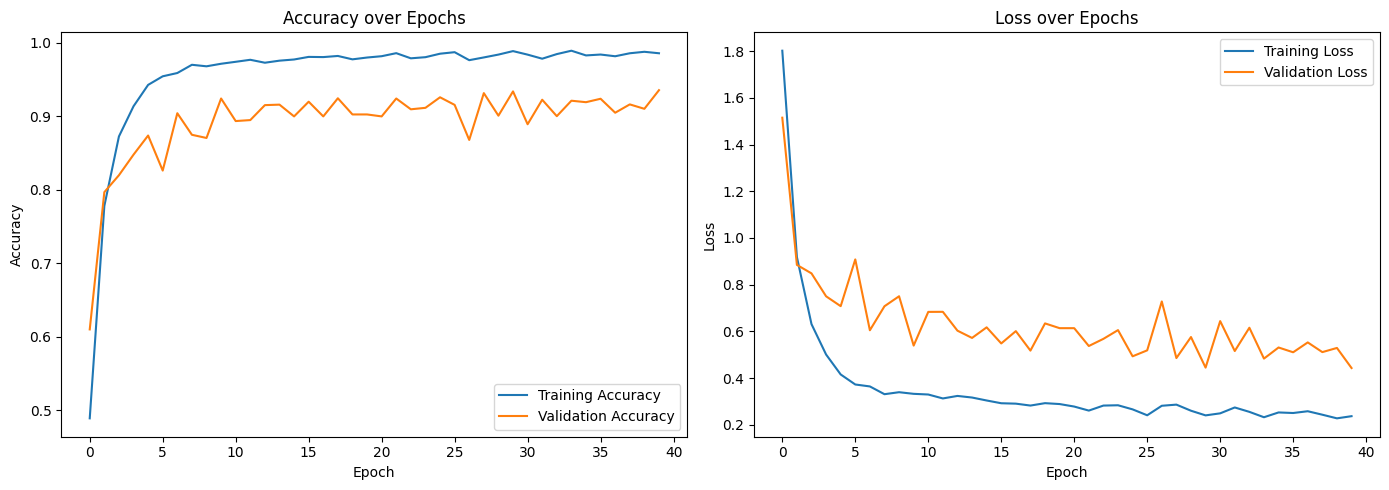

In [ ]:
plot_training_history(history) #128x128 image size model plot

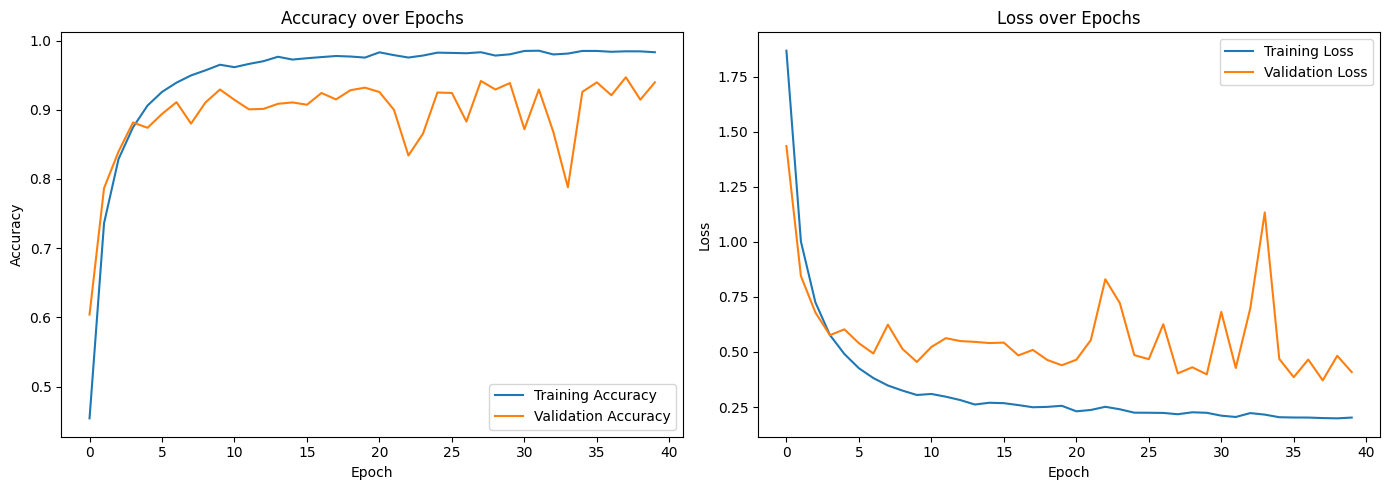

In [ ]:
plot_training_history(history) #previous 64x64 size plot

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


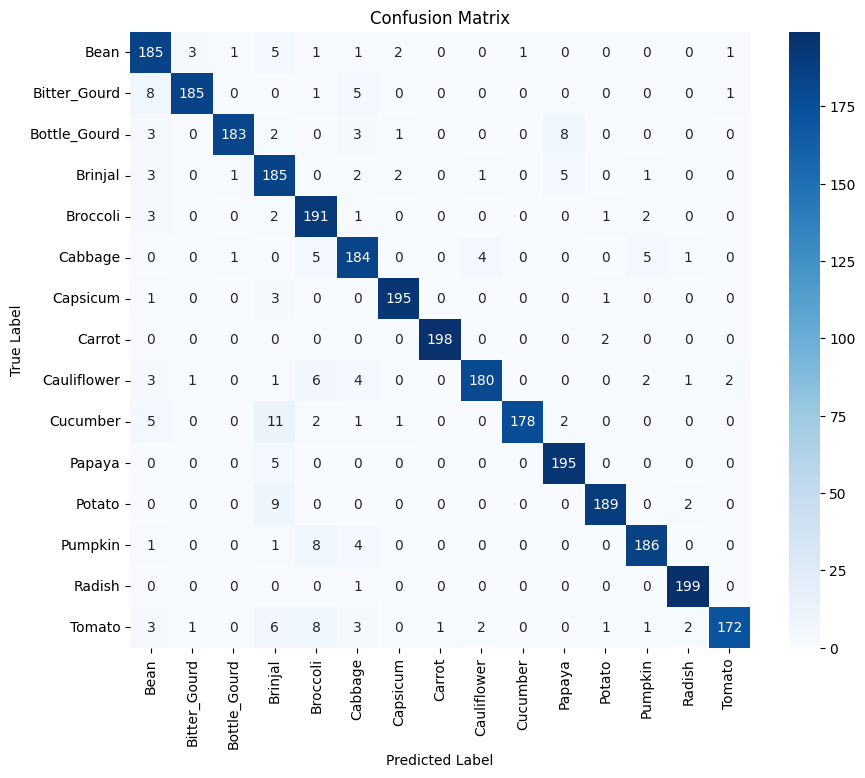

In [ ]:
plot_confusion_matrix(test_ds)

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step


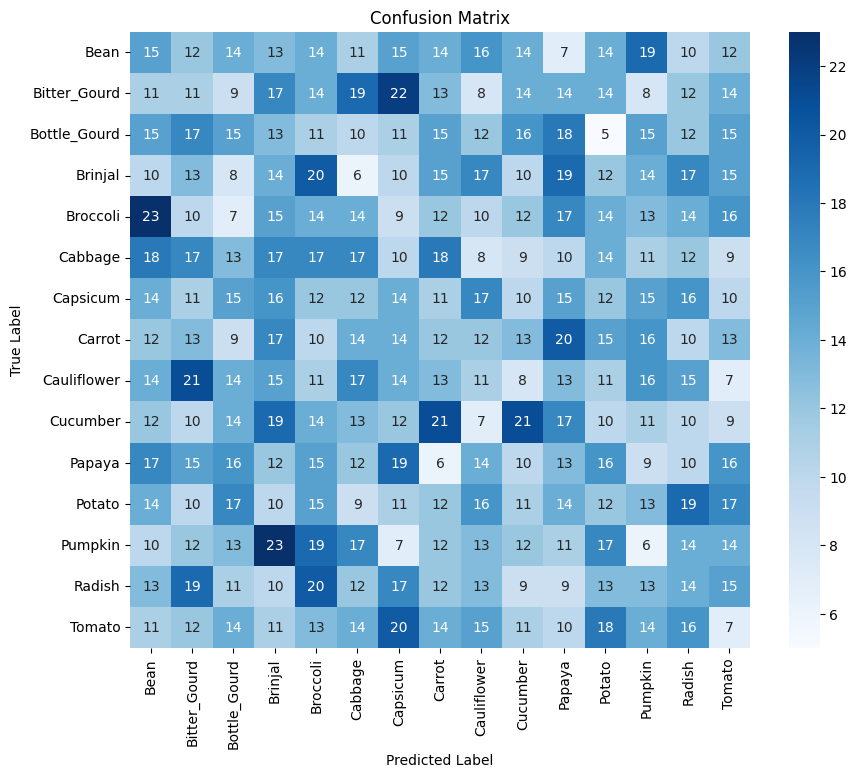

In [ ]:
plot_confusion_matrix(val_ds)

469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step


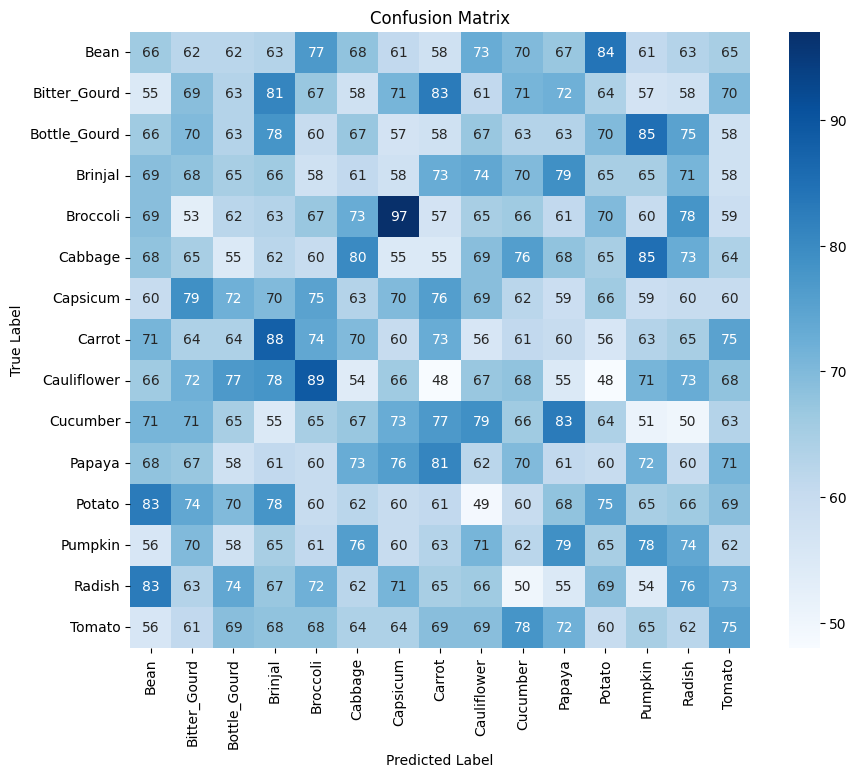

In [ ]:
plot_confusion_matrix(train_ds)

In [ ]:
print(class_names)

['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']


##**Predictions**

In [ ]:
def predict_vegetable(model, image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    print(img_array.shape)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    print(img_array.shape)
    return model.predict(img_array)

In [ ]:
model=load_model('/content/drive/MyDrive/AIEnsured/vegetable_model.keras')

(64, 64, 3)
(1, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [ ]:
pred = predict_vegetable(model, "/content/download.jpg")

(64, 64, 3)
(1, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


In [ ]:
pred = tf.nn.softmax(pred, axis=1)
print(pred)
a=np.argmax(pred)
print(class_names[a])

tf.Tensor([[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 15), dtype=float32)
Bean


In [ ]:
# Get a batch of images and labels from the training dataset
for images, labels in val_ds.take(1):
    break

# Make predictions on the batch
predictions = model.predict(images)

# Get the predicted class indices
predicted_indices = np.argmax(tf.nn.softmax(predictions), axis=1)

# Compare true and predicted class names for the batch
print("True Class Name | Predicted Class Name")
print("---------------------------------------")
for i in range(images.shape[0]):
    true_class_name = class_names[labels[i]]
    predicted_class_name = class_names[predicted_indices[i]]
    print(f"{true_class_name:<15} | {predicted_class_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
True Class Name | Predicted Class Name
---------------------------------------
Pumpkin         | Pumpkin
Bitter_Gourd    | Bitter_Gourd
Potato          | Potato
Pumpkin         | Pumpkin
Capsicum        | Capsicum
Radish          | Radish
Bottle_Gourd    | Bottle_Gourd
Cauliflower     | Cauliflower
Cabbage         | Bean
Cauliflower     | Cauliflower
Pumpkin         | Pumpkin
Cucumber        | Cucumber
Brinjal         | Brinjal
Capsicum        | Capsicum
Broccoli        | Broccoli
Cauliflower     | Cauliflower
Papaya          | Papaya
Pumpkin         | Pumpkin
Cucumber        | Cucumber
Capsicum        | Capsicum
Cabbage         | Cabbage
Cucumber        | Cucumber
Bitter_Gourd    | Bitter_Gourd
Bitter_Gourd    | Bitter_Gourd
Broccoli        | Broccoli
Capsicum        | Capsicum
Cauliflower     | Pumpkin
Brinjal         | Brinjal
Capsicum        | Capsicum
Capsicum        | Capsicum
Bitter_Gourd    | Bitter_Gourd
Radish          | Radish


#**ResNet50 Model Implementation using Tensorflow**

##**Model Architecure**

In [ ]:
def build_resnet50_model(input_shape, num_classes):

    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # for layer in base_model.layers:
    #     layer.trainable = False

    x = base_model.output
    x = Flatten()(x)

    x = Dense(128, activation='relu', kernel_regularizer=l2(0.005))(x)
    x = Dropout(0.45)(x)

    x = Dense(256, activation='relu', kernel_regularizer=l2(0.005))(x)
    x = Dropout(0.55)(x)


    predictions = Dense(num_classes, activation='linear')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])

    return model

In [ ]:
resnet_model = build_resnet50_model(input_shape=(target_size[0], target_size[1], 3), num_classes=Veggies_count)
resnet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 27,819,023 (106.12 MB)

 Trainable params: 27,765,903 (105.92 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
resnet_model = build_resnet50_model(input_shape=(target_size[0], target_size[1], 3), num_classes=Veggies_count)

# Train the ResNet50 model
history_resnet = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    verbose=1
)

Epoch 1/10
418/469 ━━━━━━━━━━━━━━━━━━━━ 7:12 8s/step - accuracy: 0.3991 - loss: 3.9503

In [ ]:
test_loss_resnet, test_accuracy_resnet = resnet_model.evaluate(test_ds)
print(f"\nResNet50 Test Accuracy: {test_accuracy_resnet:.4f}")
print(f"ResNet50 Test Loss: {test_loss_resnet:.4f}")

In [ ]:
plot_training_history(history_resnet)

94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 85ms/step


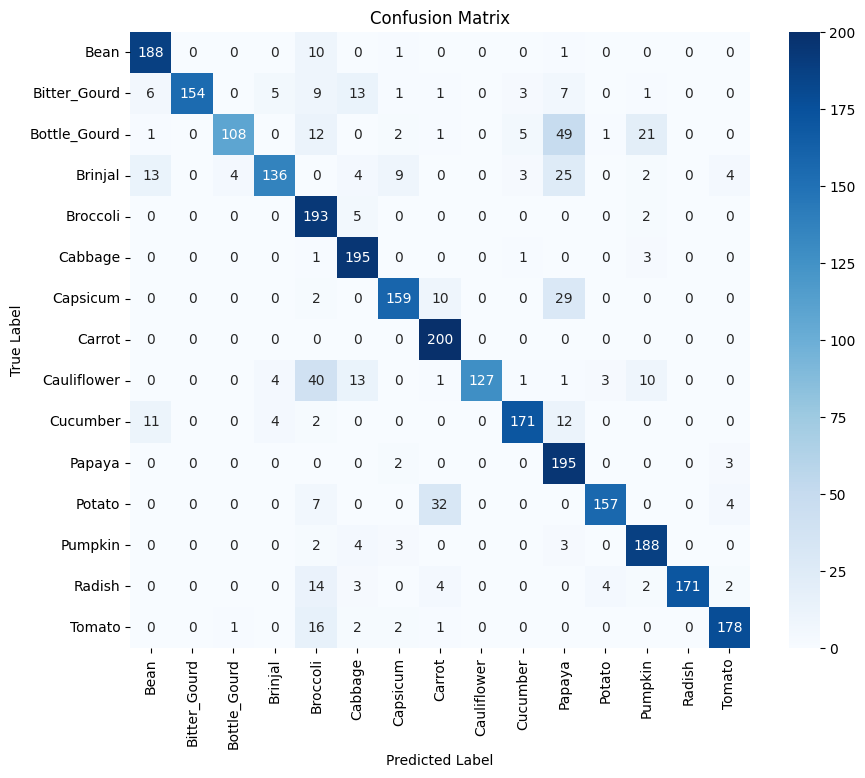

In [ ]:
plot_confusion_matrix(resnet_model, test_ds, class_names)

469/469 ━━━━━━━━━━━━━━━━━━━━ 34s 72ms/step


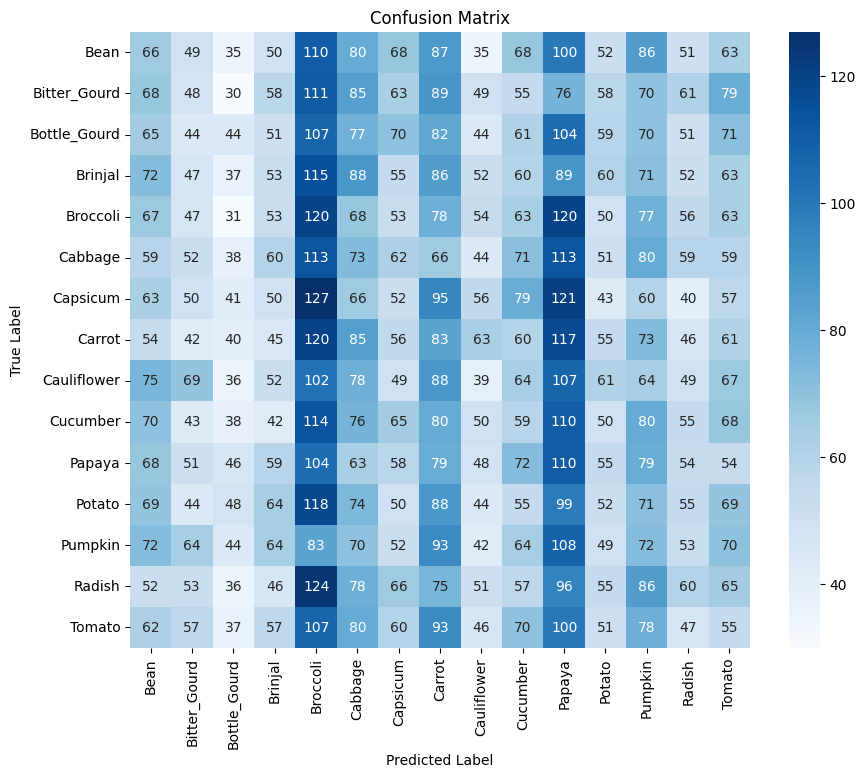

In [ ]:
plot_confusion_matrix(resnet_model, train_ds, class_names)

94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step


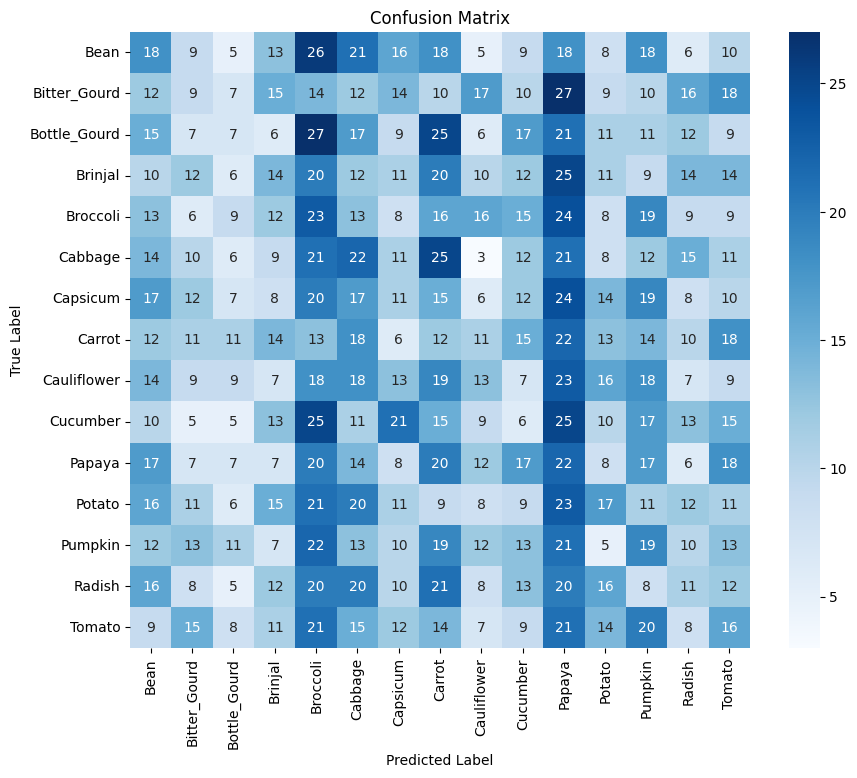

In [ ]:
plot_confusion_matrix(resnet_model, val_ds, class_names)

#**Resnet50 using PyTorch**

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

# Define the PyTorch dataset
class VegetableDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.class_names = sorted(os.listdir(data_dir))
        self.image_paths = []
        self.labels = []
        for i, class_name in enumerate(self.class_names):
            class_path = os.path.join(data_dir, class_name)
            for img_name in os.listdir(class_path):
                self.image_paths.append(os.path.join(class_path, img_name))
                self.labels.append(i)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Define transforms
transform = transforms.Compose([
    transforms.Resize(target_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = VegetableDataset(train_dir, transform=transform)
val_dataset = VegetableDataset(os.path.join(base_dir, 'validation'), transform=transform)
test_dataset = VegetableDataset(os.path.join(base_dir, 'test'), transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Build ResNet50 model
resnet50_pytorch = models.resnet50(pretrained=True)
num_ftrs = resnet50_pytorch.fc.in_features
resnet50_pytorch.fc = nn.Linear(num_ftrs, Veggies_count)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50_pytorch.parameters(), lr=0.001)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50_pytorch.to(device)

# Training loop (example - you can add validation and testing)
num_epochs = 10

for epoch in range(num_epochs):
    resnet50_pytorch.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = resnet50_pytorch(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

print("Training finished.")